In [2]:
# libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [58]:
df = pd.read_csv('imputed_ptb_risk_file.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'imputed_ptb_risk_file.csv'

In [16]:
outcomes = ['TERM', 'preterm_lscs', 'preterm_nvd']
drop_cols = ['LSCS_MOD','LSCS_EMERGENCY','MT_BABIES_COUNT']
index_cols = ['SL.NO']
controls = ['caste_general_HINDU', 'caste_OBC_HINDU',
       'caste_SC_HINDU', 'caste_SEBC_HINDU',
        'caste_ST_HINDU', 'caste_MUSLIM',
        'Education_Undergraduate_Degree',
       'Education_Medical_Specialization', 'Education_Postgraduate_Degree',
       'Education_Others', 'Education_Doctorate_Degree',
       'Education_Basic_Education', 'Education_Engineering_Specialization',
       'Education_Diploma_Certificate' ]

idvs = ['MT_WEIGHT (KG)', 'MT_HEIGHT (CM)', 'MT_AGE (YEARS)',
        'PAROUS', 'PRVS_LSCS', 'HYPOTHYROIDISM',
        'IVF/IUI', 'PPROM', 'OLIOGOHYDRAMNIOS', 'Abortion', 'HB',
       'Preeclampsia', 'E.F.W', 'FHR', 'AFI', 'Grade', 'Cervix (cm)',
       'Anterior Placenta', 'Posterior Placenta', 'Fundal Placenta',
       'Lateral Placenta', 'Right Lateral Posterior Placenta',
       'Fundo-Anterior Placenta', 'Fundo-Posterior Placenta', 'Separation',
       'Transverse Position', 'Cephalic Position', 'Breech Position','Planceta_PREVIA',
       'Hypertension']



In [17]:
df1 = df.drop(columns=drop_cols).set_index('SL.NO')
df2 = df1[idvs + controls + outcomes + ['GA_Extracted(weeks)']]
df2['BMI'] = df2['MT_WEIGHT (KG)'] / ((df2['MT_HEIGHT (CM)']/100)**2)
df2.drop(columns=['MT_HEIGHT (CM)'], inplace=True)

/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_19276/3078545893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['BMI'] = df2['MT_WEIGHT (KG)'] / ((df2['MT_HEIGHT (CM)']/100)**2)


In [18]:
idvs = ['MT_WEIGHT (KG)', 'MT_AGE (YEARS)',
        'PAROUS', 'PRVS_LSCS', 'HYPOTHYROIDISM',
        'IVF/IUI', 'PPROM', 'OLIOGOHYDRAMNIOS', 'Abortion', 'HB',
       'Preeclampsia', 'E.F.W', 'FHR', 'AFI', 'Grade', 'Cervix (cm)',
       'Anterior Placenta', 'Posterior Placenta', 'Fundal Placenta',
       'Lateral Placenta', 'Right Lateral Posterior Placenta',
       'Fundo-Anterior Placenta', 'Fundo-Posterior Placenta', 'Separation',
       'Transverse Position', 'Cephalic Position', 'Breech Position','Planceta_PREVIA',
       'Hypertension','BMI']

# plt.figure(figsize = (10,10))
# sns.heatmap(df2[idvs+outcomes].corr())
def encode_parous(parous_value):
    if parous_value == 0:
        return 'Nulliparous'
    else:
        return 'Multiparous'
    
# preterm types definition
df2['late_preterm'] = df2['GA_Extracted(weeks)'].apply(lambda x: 1 if 34 <= x < 37 else 0)
df2['mod_preterm'] = df2['GA_Extracted(weeks)'].apply(lambda x: 1 if 32 <= x < 34 else 0)
df2['very_preterm'] = df2['GA_Extracted(weeks)'].apply(lambda x: 1 if 28 <= x < 32 else 0)
df2['ext_preterm'] = df2['GA_Extracted(weeks)'].apply(lambda x: 1 if x < 28 else 0)

outcome_labels = {
    'TERM': 'Pre-Term',
    'preterm_lscs': 'Pre-Term & LSCS',
    'preterm_nvd': 'Pre-Term & NVD'
}

df2['PAROUS_ENCODED'] = df2['PAROUS'].apply(encode_parous)
df2.dropna(inplace=True)

In [27]:
df2['TERM'].value_counts()

TERM
 0.0    559
 1.0    175
-1.0      2
Name: count, dtype: int64

In [30]:
df2[df2['TERM']==0]['GA_Extracted(weeks)'].max()

41

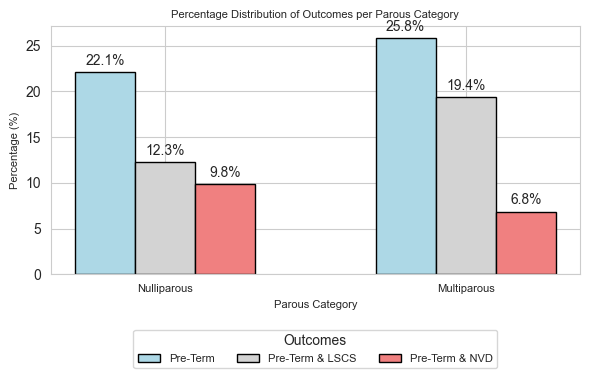

In [264]:
# OUTCOME DISTRIBUTION BY PAROUS CATEOGORY

outcome_percentages = df2.groupby('PAROUS_ENCODED')[outcomes].apply(lambda x: (x.sum() / x.count()) * 100)
outcome_percentages = outcome_percentages.reindex(['Nulliparous', 'Multiparous'])

fig, ax = plt.subplots(figsize=(6, 4))
n_parous = len(outcome_percentages)
bar_width = 0.2
index = np.arange(n_parous)
colors = ['lightblue', 'lightgray', 'lightcoral']
for i, outcome in enumerate(outcomes):
    bars = ax.bar(index + i * bar_width, outcome_percentages[outcome], bar_width, label=outcome_labels[outcome], 
                  edgecolor='black', color=colors[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
        
ax.set_title('Percentage Distribution of Outcomes per Parous Category', fontsize=8)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(outcome_percentages.index, fontsize=8)
ax.set_xlabel('Parous Category', fontsize=8)
ax.set_ylabel('Percentage (%)', fontsize=8)
ax.legend(title="Outcomes", loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8, ncol=3)
plt.tight_layout()
plt.show()

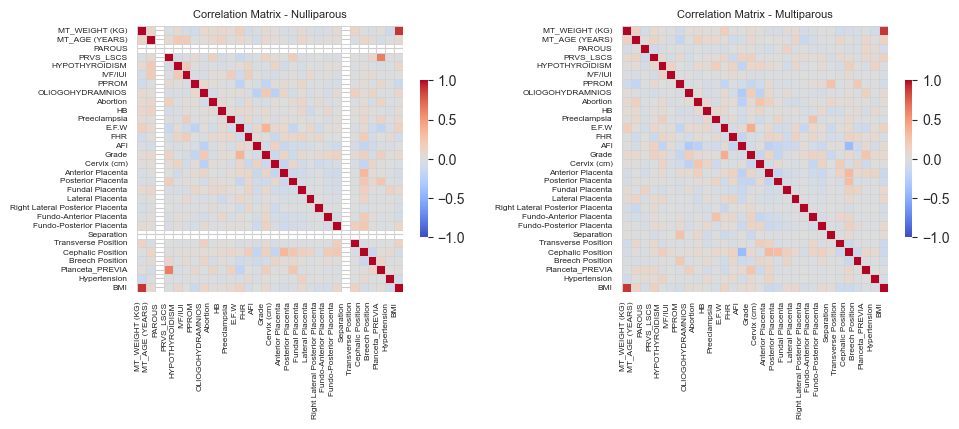

In [269]:
# FEATURE CORRELATION BY PAROUS CATEOGORY
import numpy as np

fig, axes = plt.subplots(1, len(parous_categories), figsize=(10, 6))  # Increased width
plt.subplots_adjust(hspace=0.6, wspace=0.5)

parous_categories = df2['PAROUS_ENCODED'].unique()

for i, parous_value in enumerate([ 'Nulliparous','Multiparous']):
    parous_df = df2[df2['PAROUS_ENCODED'] == parous_value]
    parous_label = parous_mapping.get(parous_value, str(parous_value))
    corr_matrix = parous_df[idvs].corr()
    
    sns.heatmap(corr_matrix, 
                annot=False, 
                cmap="coolwarm", 
                ax=axes[i],
                cbar_kws={'orientation': 'vertical', 'shrink': 0.3},
                square=True,
                linewidths=0.5,
                linecolor='lightgrey',
                vmax=1.0,
                vmin=-1.0)
    
    axes[i].set_title(f'Correlation Matrix - {parous_label}', fontsize=8)  
    axes[i].set_xticks(np.arange(len(idvs)))
    axes[i].set_xticklabels(idvs, rotation=90, fontsize=6)  # Ensure all tick labels are shown
    axes[i].tick_params(axis='y', labelsize=6)

plt.tight_layout(pad=2.0)
plt.show()


In [187]:
df2['PAROUS_ENCODED'].value_counts()

PAROUS_ENCODED
Nulliparous     457
Primi Parous    244
Multiparous      35
Name: count, dtype: int64

In [271]:
idvs = ['MT_WEIGHT (KG)', 'MT_AGE (YEARS)', 'PRVS_LSCS', 'HYPOTHYROIDISM',
        'IVF/IUI', 'PPROM', 'OLIOGOHYDRAMNIOS', 'Abortion', 'HB',
       'Preeclampsia', 'E.F.W', 'FHR', 'AFI', 'Grade', 'Cervix (cm)',
       'Anterior Placenta', 'Posterior Placenta', 'Fundal Placenta',
       'Lateral Placenta', 'Right Lateral Posterior Placenta',
       'Fundo-Anterior Placenta', 'Fundo-Posterior Placenta', 'Separation',
       'Transverse Position', 'Cephalic Position', 'Breech Position','Planceta_PREVIA',
       'Hypertension','BMI']

In [272]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import statsmodels.api as sm

# Drop the 'PAROUS' column
data = df2.drop(columns=['PAROUS'])

# Replace -1 with 0 in 'TERM'
data['TERM'] = data['TERM'].replace(-1, 0)

# Define outcome columns and independent variables (idvs)
outcome_columns = ['TERM', 'preterm_lscs', 'preterm_nvd']
idvs = ['MT_WEIGHT (KG)', 'MT_AGE (YEARS)', 'PRVS_LSCS',
        'HYPOTHYROIDISM', 'IVF/IUI', 'PPROM', 'OLIOGOHYDRAMNIOS', 'Abortion',
        'HB', 'Preeclampsia', 'E.F.W', 'FHR', 'AFI', 'Grade', 'Cervix (cm)',
        'Anterior Placenta', 'Posterior Placenta', 'Fundal Placenta',
        'Lateral Placenta', 'Right Lateral Posterior Placenta',
        'Fundo-Anterior Placenta', 'Fundo-Posterior Placenta', 'Separation',
        'Transverse Position', 'Cephalic Position', 'Breech Position',
        'Planceta_PREVIA', 'Hypertension','BMI']

numeric_features = ['MT_WEIGHT (KG)', 'MT_AGE (YEARS)' ,'E.F.W', 'FHR', 'AFI','Grade', 'Cervix (cm)','BMI']

# Standardize numeric features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Function to run Regularized logistic regression with L2 penalty for each category of 'PAROUS_ENCODED'
def run_logistic_regression(df, idvs, outcome):
    results = []
    parous_types = df['PAROUS_ENCODED'].unique()
    for parous_type in parous_types:
        df_filtered = df[df['PAROUS_ENCODED'] == parous_type].copy()
        X = df_filtered[idvs]
        y = df_filtered[outcome]
        X = sm.add_constant(X)  # Adding a constant term for intercept
        model = sm.Logit(y, X)
        result = model.fit_regularized(method='l1', alpha=0.1)
        coef = result.params
        ci = result.conf_int()
        p_values = result.pvalues

        # Collecting results
        for feature in idvs:
            results.append([parous_type, outcome, feature, coef[feature], ci.loc[feature, 0], ci.loc[feature, 1], p_values[feature]])
    
    return results

# Run the models and store the results
all_results = []
for outcome in outcome_columns:
    result = run_logistic_regression(data, idvs, outcome)
    all_results.extend(result)

# Create DataFrame with results
columns = ['Parous Type', 'Outcome Type', 'Feature', 'Coefficient', '95% CI Lower', '95% CI Upper', 'P-value']
results_df = pd.DataFrame(all_results, columns=columns)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4332683516254297
            Iterations: 225
            Function evaluations: 228
            Gradient evaluations: 225
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.32634948132202496
            Iterations: 259
            Function evaluations: 262
            Gradient evaluations: 259
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3608546701496403
            Iterations: 284
            Function evaluations: 286
            Gradient evaluations: 284
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2944731921152873
            Iterations: 293
            Function evaluations: 296
            Gradient evaluations: 293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1523661522241577
            Iterations: 256
          

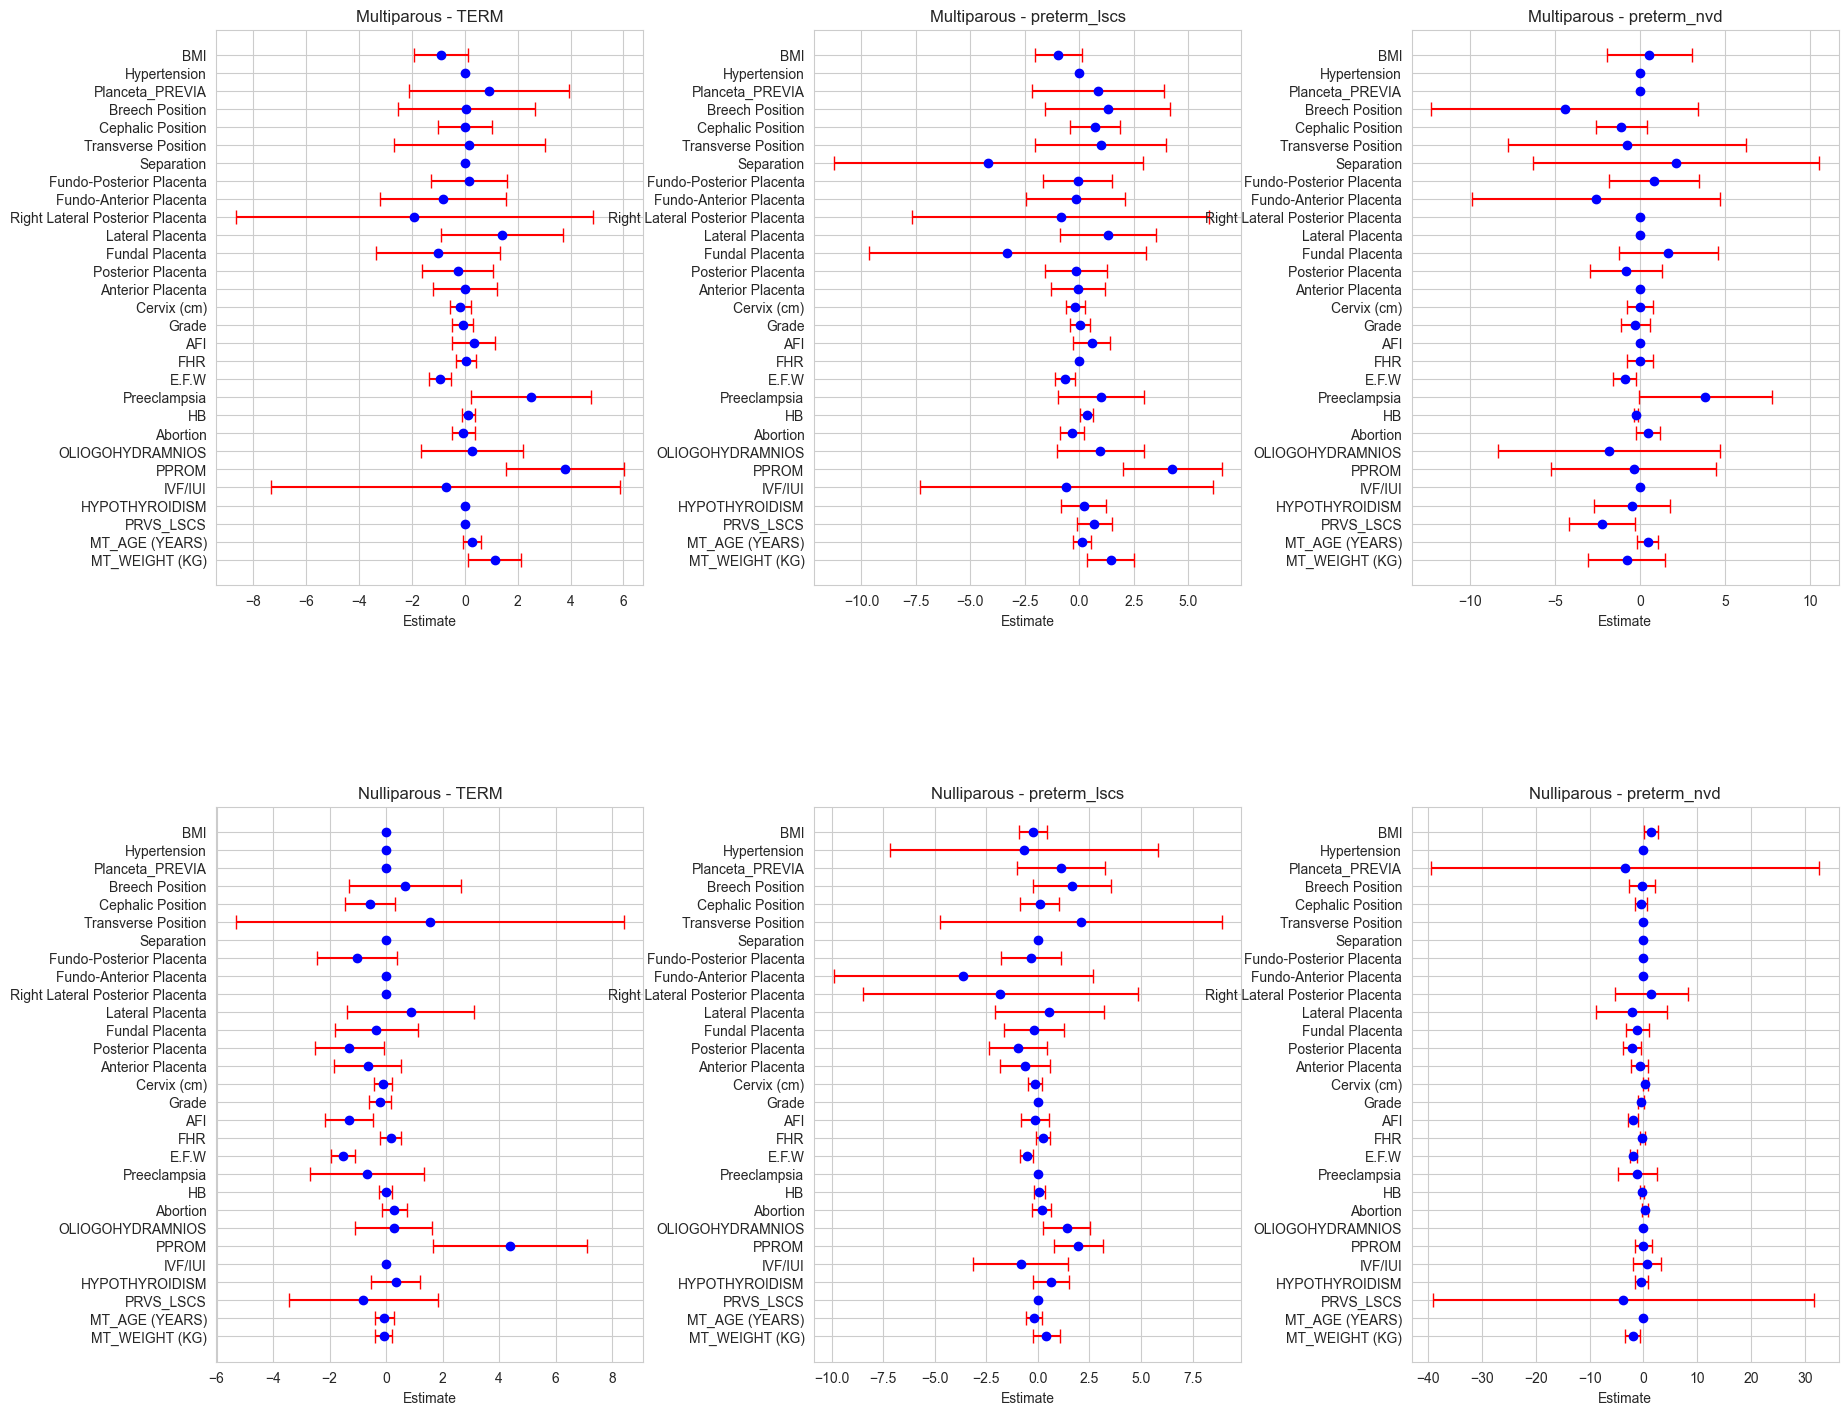

In [274]:
parous_types = results_df['Parous Type'].unique()
outcome_types = results_df['Outcome Type'].unique()

# Function to plot estimates with confidence intervals for each Parous Type and Outcome Type
def plot_ci_intervals(df, parous_type, outcome_type, ax):
    subset_df = df[(df['Parous Type'] == parous_type) & (df['Outcome Type'] == outcome_type)]
    
    # Error bar plot showing coefficient with CI intervals
    ax.errorbar(subset_df['Coefficient'], subset_df['Feature'], 
                xerr=[subset_df['Coefficient'] - subset_df['95% CI Lower'], subset_df['95% CI Upper'] - subset_df['Coefficient']],
                fmt='o', color='b', ecolor='r', capsize=5)
    
    ax.set_xlabel('Estimate')
    ax.set_title(f'{parous_type} - {outcome_type}')

# Set up a 3x3 grid for the plots
fig, axes = plt.subplots(2, 3, figsize=(18, 15))
fig.tight_layout(pad=5.0)

# Iterate over each combination of Parous Type and Outcome Type and plot in the grid
for i, parous_type in enumerate(parous_types):
    for j, outcome_type in enumerate(outcome_types):
        ax = axes[i, j]
        plot_ci_intervals(results_df, parous_type, outcome_type, ax)

# Adjust layout for better display
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


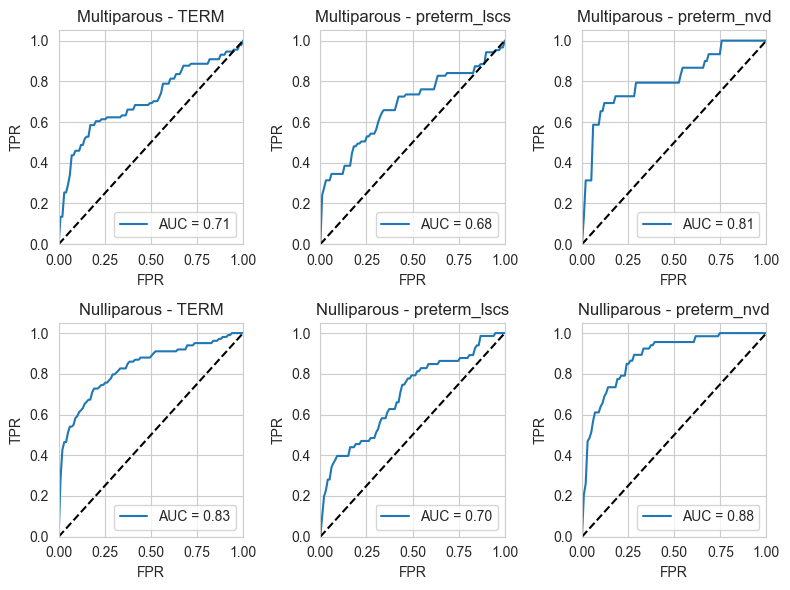

In [277]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

numeric_features = ['MT_WEIGHT (KG)', 'MT_AGE (YEARS)' ,'E.F.W', 'FHR', 'AFI','Grade', 'Cervix (cm)','BMI']

def simple_cv_mean_roc_logistic(df, idvs, outcome, numeric_features):
    parous_types = df['PAROUS_ENCODED'].unique()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_results = []

    for parous_type in parous_types:
        df_filtered = df[df['PAROUS_ENCODED'] == parous_type]
        X = df_filtered[idvs].copy()  # Make a copy of the independent variables
        y = df_filtered[outcome].values  # Convert target to numpy array

        if len(np.unique(y)) < 2:
            continue  # Skip if only one class is present

        # Standardize only the numeric features
        scaler = StandardScaler()
        X[numeric_features] = scaler.fit_transform(X[numeric_features])

        logistic_model = LogisticRegression(random_state=42, max_iter=1000)
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)

        valid_folds = 0  # To track valid folds

        for train_index, test_index in cv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Skip fold if there are no positive or negative samples in the test set
            if len(np.unique(y_test)) < 2:
                continue

            logistic_model.fit(X_train, y_train)
            y_proba = logistic_model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate to ensure same FPR across folds
            tprs[-1][0] = 0.0
            valid_folds += 1

        if valid_folds > 0:
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0  # Ensure that the last point is at 1.0
            roc_auc = auc(mean_fpr, mean_tpr)

            roc_results.append((parous_type, outcome, mean_fpr, mean_tpr, roc_auc))
    
    return roc_results

# Get mean ROC curves for Logistic Regression
simple_mean_auc_results_with_logistic = []
for outcome in outcome_columns:
    roc_result = simple_cv_mean_roc_logistic(data, idvs, outcome, numeric_features)
    simple_mean_auc_results_with_logistic.extend(roc_result)

# Function to plot mean ROC curves in a 3x3 grid
def plot_mean_auc_roc_3x3(roc_results):
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))

    parous_outcome_combinations = [(p, o) for p in data['PAROUS_ENCODED'].unique() for o in outcome_columns]
    
    for i, (parous_type, outcome) in enumerate(parous_outcome_combinations):
        ax = axes[i // 3, i % 3]
        result_subset = [r for r in roc_results if r[0] == parous_type and r[1] == outcome]
        if result_subset:
            for _, _, mean_fpr, mean_tpr, roc_auc in result_subset:
                ax.plot(mean_fpr, mean_tpr, label=f'AUC = {roc_auc:.2f}')
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.set_title(f'{parous_type} - {outcome}')
            ax.legend(loc="lower right")
        else:
            ax.set_title(f'{parous_type} - {outcome}\n(No valid ROC curve)')

    plt.tight_layout()
    plt.show()

# Plot the mean ROC curves for Logistic Regression
plot_mean_auc_roc_3x3(simple_mean_auc_results_with_logistic)


In [240]:
controls

['caste_general_HINDU',
 'caste_OBC_HINDU',
 'caste_SC_HINDU',
 'caste_SEBC_HINDU',
 'caste_ST_HINDU',
 'caste_MUSLIM',
 'Education_Undergraduate_Degree',
 'Education_Medical_Specialization',
 'Education_Postgraduate_Degree',
 'Education_Others',
 'Education_Doctorate_Degree',
 'Education_Basic_Education',
 'Education_Engineering_Specialization',
 'Education_Diploma_Certificate']

In [241]:
!pip install pyfixest

  Obtaining dependency information for pyfixest from https://files.pythonhosted.org/packages/c0/99/b57491e97cc46e55bbd7c6a760d161d6a9e58acadce08790024fca2f2dd3/pyfixest-0.24.2-py3-none-any.whl.metadata
  Obtaining dependency information for formulaic>=1.0.0 from https://files.pythonhosted.org/packages/f7/a3/eeb29e0dbfd6ef0bafd0b3107649e0b8a02b382265f5e9572c7bda22eeff/formulaic-1.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for great-tables>=0.10.0 from https://files.pythonhosted.org/packages/bd/c8/ad99edd462d625108e5a7fdd5695086f97ce3949b40a175b36cfa0558873/great_tables-0.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for lets-plot>=4.0.1 from https://files.pythonhosted.org/packages/86/49/a7ffbceceff2d1e2aa48b49b141a54052c5c362045f0d5e9e6f1cdc35cae/lets_plot-4.4.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for polars>=0.20.1 from https://files.pythonhosted.org/packages/ae/53/7daa3dd2fd6d8728c3363b342fbf1f804a5612e

In [246]:
# Significant features
results_df[results_df['P-value']<.05].sort_values(by=['Parous Type','Outcome Type'] ,ascending=False)

,Parous Type,Outcome Type,Feature,Coefficient,95% CI Lower,95% CI Upper,P-value
234,Primi Parous,preterm_nvd,PRVS_LSCS,-2.914322,-5.431557,-0.397086,2.325968e-02
241,Primi Parous,preterm_nvd,Preeclampsia,4.338654,0.136578,8.540729,4.300434e-02
242,Primi Parous,preterm_nvd,E.F.W,-0.773359,-1.411972,-0.134745,1.761995e-02
145,Primi Parous,preterm_lscs,MT_WEIGHT (KG),1.482365,0.214548,2.750183,2.192637e-02
150,Primi Parous,preterm_lscs,PPROM,6.140058,1.469482,10.810634,9.977196e-03
153,Primi Parous,preterm_lscs,HB,0.502854,0.135987,0.869721,7.221237e-03
155,Primi Parous,preterm_lscs,E.F.W,-0.781693,-1.319136,-0.244251,4.362198e-03
169,Primi Parous,preterm_lscs,Cephalic Position,1.325891,0.147617,2.504165,2.741807e-02
63,Primi Parous,TERM,PPROM,8.053076,0.290710,15.815442,4.201545e-02
66,Primi Parous,TERM,HB,0.328309,0.016147,0.640472,3.927025e-02


In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfixest import feols
import pyfixest as pf

from sklearn.preprocessing import StandardScaler


fixed_effect_controls = ['caste_general_HINDU', 'caste_OBC_HINDU', 'caste_SC_HINDU', 'caste_SEBC_HINDU',
                         'caste_ST_HINDU', 'caste_MUSLIM', 'Education_Undergraduate_Degree', 
                         'Education_Medical_Specialization', 'Education_Postgraduate_Degree', 
                         'Education_Others', 'Education_Doctorate_Degree', 'Education_Basic_Education', 
                         'Education_Engineering_Specialization', 'Education_Diploma_Certificate']

df2.columns = df2.columns.str.replace(' ', '_')

df2 = df2.rename(columns={'IVF/IUI':'IVF_IUI',
                          'MT_WEIGHT_(KG)':'MT_WEIGHT',
                          'MT_AGE_(YEARS)':'MT_AGE',
                          'E.F.W':'EFW',
                          'Cervix_(cm)':'Cervix',
                          'Fundo-Anterior_Placenta':'Fundo_Anterior_Placenta',
                          'Fundo-Posterior_Placenta':'Fundo_Posterior_Placenta'
                         })


idvs = ['MT_WEIGHT', 'MT_AGE', 'PRVS_LSCS',
       'HYPOTHYROIDISM', 'IVF_IUI', 'PPROM', 'OLIOGOHYDRAMNIOS', 'Abortion',
       'HB', 'Preeclampsia', 'EFW', 'FHR', 'AFI', 'Grade', 'Cervix',
       'Anterior_Placenta', 'Posterior_Placenta', 'Fundal_Placenta',
       'Lateral_Placenta', 'Right_Lateral_Posterior_Placenta',
       'Fundo_Anterior_Placenta', 'Fundo_Posterior_Placenta', 'Separation',
       'Transverse_Position', 'Cephalic_Position', 'Breech_Position',
       'Planceta_PREVIA', 'Hypertension', 'BMI']

numeric_features = ['MT_WEIGHT', 'MT_AGE' ,'EFW', 'FHR', 'AFI','Grade', 'Cervix','BMI']

data = df2.drop(columns=['PAROUS'])

# Updated function to store results into a DataFrame
def run_fixed_effect_logistic_feols(df, idvs, outcome, fixed_effects, numeric_features):
    parous_types = df['PAROUS_ENCODED'].unique()
    all_estimates = []  # To store all results for each parous type and outcome

    for parous_type in parous_types:
        print('--------------------------------------------------')
        print(parous_type, outcome)
        print('--------------------------------------------------')
        
        df_filtered = df[df['PAROUS_ENCODED'] == parous_type].copy()
        
        # Standardize numeric features
        scaler = StandardScaler()
        df_filtered[numeric_features] = scaler.fit_transform(df_filtered[numeric_features])
        
        # Create the formula with fixed effects
        formula = f"{outcome} ~ " + " + ".join(idvs) + " | " + " + ".join(fixed_effects)
        print(formula)

        # Fit the model using feols
        result = pf.feols(formula, df_filtered[idvs + [outcome] + fixed_effects])
        
        # Extract coefficients, confidence intervals, and p-values from the result object
        coefs = result.coef()
        std_errs = result.se
        conf_int = result.confint()  # 95% confidence interval
        p_values = result.pvalue()

        # Store the results in the all_estimates list
        for feature in coefs.index:
            all_estimates.append([
                parous_type,
                outcome,
                feature,
                coefs[feature],
                conf_int.loc[feature][0],  # Confidence Interval lower bound
                conf_int.loc[feature][1],  # Confidence Interval upper bound
                p_values[feature]
            ])
    
    # Convert the list of estimates to a pandas DataFrame
    results_df = pd.DataFrame(all_estimates, columns=[
        'Parous Type', 'Outcome Type', 'Feature', 'Coefficient', '95% CI Lower', '95% CI Upper', 'P-value'
    ])
    
    return results_df

# Run the models and store the results
all_results = []
for outcome in outcome_columns:
    results_df = run_fixed_effect_logistic_feols(data, idvs, outcome, fixed_effect_controls, numeric_features)
    all_results.append(results_df)

# Combine results from all outcomes into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)



--------------------------------------------------
Multiparous TERM
--------------------------------------------------
TERM ~ MT_WEIGHT + MT_AGE + PRVS_LSCS + HYPOTHYROIDISM + IVF_IUI + PPROM + OLIOGOHYDRAMNIOS + Abortion + HB + Preeclampsia + EFW + FHR + AFI + Grade + Cervix + Anterior_Placenta + Posterior_Placenta + Fundal_Placenta + Lateral_Placenta + Right_Lateral_Posterior_Placenta + Fundo_Anterior_Placenta + Fundo_Posterior_Placenta + Separation + Transverse_Position + Cephalic_Position + Breech_Position + Planceta_PREVIA + Hypertension + BMI | caste_general_HINDU + caste_OBC_HINDU + caste_SC_HINDU + caste_SEBC_HINDU + caste_ST_HINDU + caste_MUSLIM + Education_Undergraduate_Degree + Education_Medical_Specialization + Education_Postgraduate_Degree + Education_Others + Education_Doctorate_Degree + Education_Basic_Education + Education_Engineering_Specialization + Education_Diploma_Certificate


/Users/pthatoi/PycharmProjects/Rhumatoid_Arthiritis/.venv/lib/python3.9/site-packages/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['IVF_IUI', 'OLIOGOHYDRAMNIOS', 'Preeclampsia', 'Fundal_Placenta', 'Lateral_Placenta', 'Right_Lateral_Posterior_Placenta', 'Separation', 'Breech_Position'].
            The variables are dropped from the model.
            
  warnings.warn(
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[feature][0],  # Confidence Interval lower bound
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys w

--------------------------------------------------
Nulliparous TERM
--------------------------------------------------
TERM ~ MT_WEIGHT + MT_AGE + PRVS_LSCS + HYPOTHYROIDISM + IVF_IUI + PPROM + OLIOGOHYDRAMNIOS + Abortion + HB + Preeclampsia + EFW + FHR + AFI + Grade + Cervix + Anterior_Placenta + Posterior_Placenta + Fundal_Placenta + Lateral_Placenta + Right_Lateral_Posterior_Placenta + Fundo_Anterior_Placenta + Fundo_Posterior_Placenta + Separation + Transverse_Position + Cephalic_Position + Breech_Position + Planceta_PREVIA + Hypertension + BMI | caste_general_HINDU + caste_OBC_HINDU + caste_SC_HINDU + caste_SEBC_HINDU + caste_ST_HINDU + caste_MUSLIM + Education_Undergraduate_Degree + Education_Medical_Specialization + Education_Postgraduate_Degree + Education_Others + Education_Doctorate_Degree + Education_Basic_Education + Education_Engineering_Specialization + Education_Diploma_Certificate
--------------------------------------------------
Primi Parous TERM
---------------------

/Users/pthatoi/PycharmProjects/Rhumatoid_Arthiritis/.venv/lib/python3.9/site-packages/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['IVF_IUI', 'OLIOGOHYDRAMNIOS', 'Preeclampsia', 'Fundal_Placenta', 'Lateral_Placenta', 'Right_Lateral_Posterior_Placenta', 'Separation', 'Breech_Position'].
            The variables are dropped from the model.
            
  warnings.warn(
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[feature][0],  # Confidence Interval lower bound
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys w

--------------------------------------------------
Nulliparous preterm_lscs
--------------------------------------------------
preterm_lscs ~ MT_WEIGHT + MT_AGE + PRVS_LSCS + HYPOTHYROIDISM + IVF_IUI + PPROM + OLIOGOHYDRAMNIOS + Abortion + HB + Preeclampsia + EFW + FHR + AFI + Grade + Cervix + Anterior_Placenta + Posterior_Placenta + Fundal_Placenta + Lateral_Placenta + Right_Lateral_Posterior_Placenta + Fundo_Anterior_Placenta + Fundo_Posterior_Placenta + Separation + Transverse_Position + Cephalic_Position + Breech_Position + Planceta_PREVIA + Hypertension + BMI | caste_general_HINDU + caste_OBC_HINDU + caste_SC_HINDU + caste_SEBC_HINDU + caste_ST_HINDU + caste_MUSLIM + Education_Undergraduate_Degree + Education_Medical_Specialization + Education_Postgraduate_Degree + Education_Others + Education_Doctorate_Degree + Education_Basic_Education + Education_Engineering_Specialization + Education_Diploma_Certificate
--------------------------------------------------
Primi Parous preterm_ls

/Users/pthatoi/PycharmProjects/Rhumatoid_Arthiritis/.venv/lib/python3.9/site-packages/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['Hypertension'].
            The variables are dropped from the model.
            
  warnings.warn(
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[feature][0],  # Confidence Interval lower bound
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[fea

--------------------------------------------------
Multiparous preterm_nvd
--------------------------------------------------
preterm_nvd ~ MT_WEIGHT + MT_AGE + PRVS_LSCS + HYPOTHYROIDISM + IVF_IUI + PPROM + OLIOGOHYDRAMNIOS + Abortion + HB + Preeclampsia + EFW + FHR + AFI + Grade + Cervix + Anterior_Placenta + Posterior_Placenta + Fundal_Placenta + Lateral_Placenta + Right_Lateral_Posterior_Placenta + Fundo_Anterior_Placenta + Fundo_Posterior_Placenta + Separation + Transverse_Position + Cephalic_Position + Breech_Position + Planceta_PREVIA + Hypertension + BMI | caste_general_HINDU + caste_OBC_HINDU + caste_SC_HINDU + caste_SEBC_HINDU + caste_ST_HINDU + caste_MUSLIM + Education_Undergraduate_Degree + Education_Medical_Specialization + Education_Postgraduate_Degree + Education_Others + Education_Doctorate_Degree + Education_Basic_Education + Education_Engineering_Specialization + Education_Diploma_Certificate
--------------------------------------------------
Nulliparous preterm_nvd
-

/Users/pthatoi/PycharmProjects/Rhumatoid_Arthiritis/.venv/lib/python3.9/site-packages/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['Separation'].
            The variables are dropped from the model.
            
  warnings.warn(
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[feature][0],  # Confidence Interval lower bound
/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_29197/4012032988.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int.loc[featu

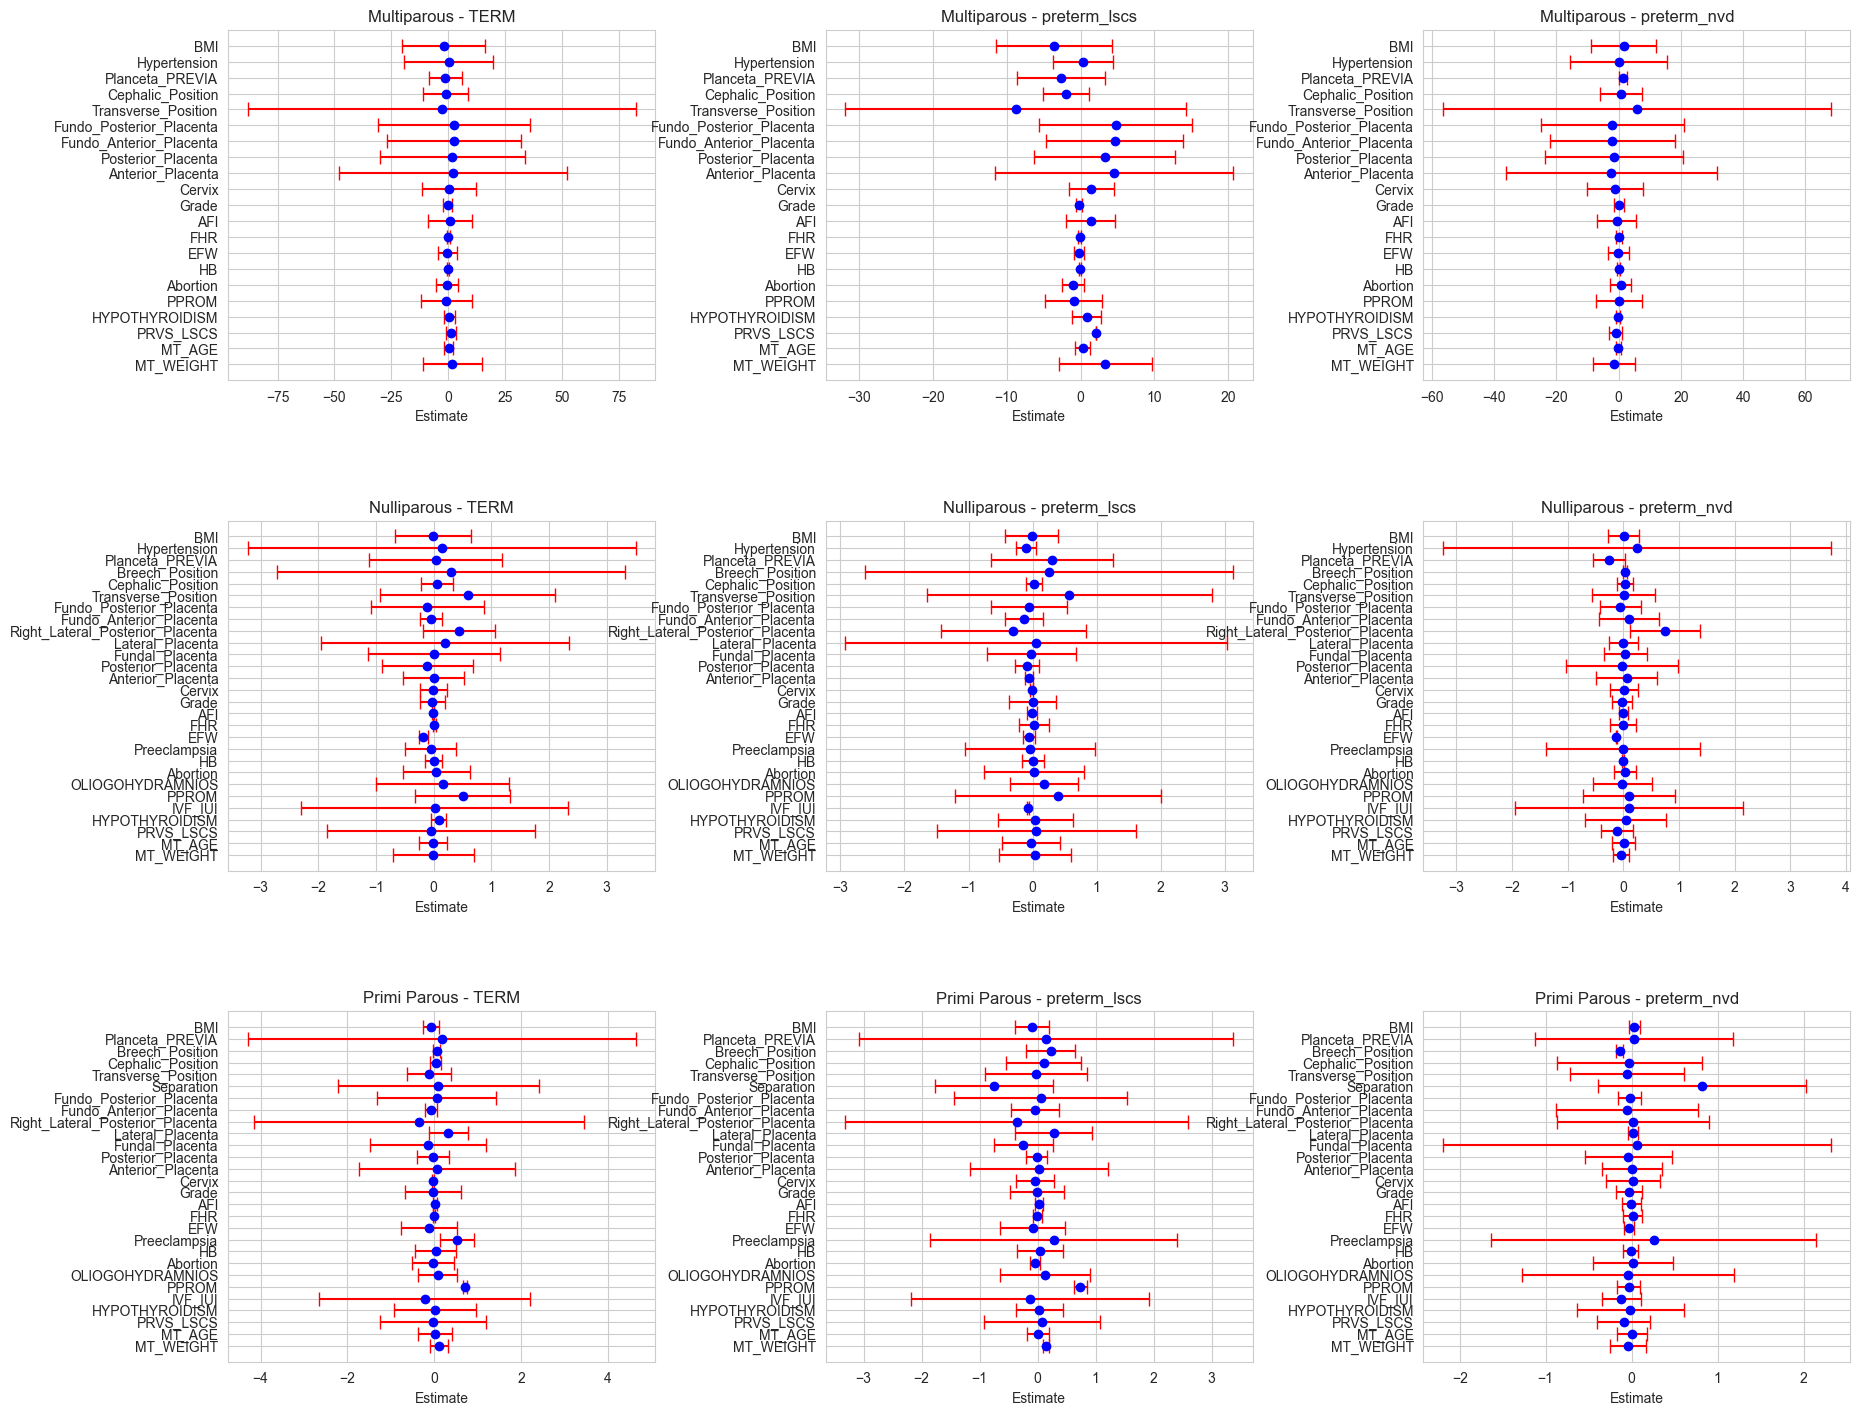

In [249]:
# Set up a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.tight_layout(pad=5.0)

# Iterate over each combination of Parous Type and Outcome Type and plot in the grid
for i, parous_type in enumerate(parous_types):
    for j, outcome_type in enumerate(outcome_types):
        ax = axes[i, j]
        plot_ci_intervals(final_results_df, parous_type, outcome_type, ax)

# Adjust layout for better display
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


In [81]:
df = pd.read_csv('/Users/pthatoi/PycharmProjects/PTB_Prediction_ML/py_scripts/res/imputed_ptb_risk_file.csv')

/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_19276/3161654622.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Outcomes", loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8, ncol=3)


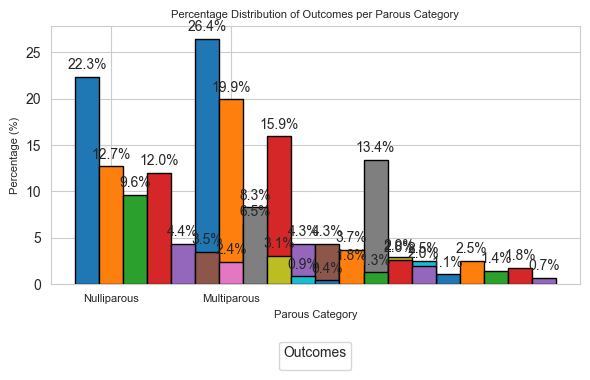

In [48]:
# OUTCOME DISTRIBUTION BY PAROUS CATEOGORY

outcomes=['TERM','preterm_lscs','preterm_nvd',
       'late_preterm', 'mod_preterm', 'very_preterm', 'ext_preterm',
        'late_preterm_lscs', 'mod_preterm_lscs', 'very_preterm_lscs', 'ext_preterm_lscs',
        'late_preterm_nvd', 'mod_preterm_nvd', 'very_preterm_nvd', 'ext_preterm_nvd' ]

outcome_percentages = df2.groupby('PAROUS_ENCODED')[outcomes].apply(lambda x: (x.sum() / x.count()) * 100)
outcome_percentages = outcome_percentages.reindex(['Nulliparous', 'Multiparous'])

fig, ax = plt.subplots(figsize=(6, 4))
n_parous = len(outcome_percentages)
bar_width = 0.2
index = np.arange(n_parous)
# colors = ['lightblue', 'lightgray', 'lightcoral']
for i, outcome in enumerate(outcomes):
    bars = ax.bar(index + i * bar_width, outcome_percentages[outcome], bar_width, 
                  # label=outcome_labels[outcome], 
                  edgecolor='black'
                  # , color=colors[i]
                  )
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
        
ax.set_title('Percentage Distribution of Outcomes per Parous Category', fontsize=8)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(outcome_percentages.index, fontsize=8)
ax.set_xlabel('Parous Category', fontsize=8)
ax.set_ylabel('Percentage (%)', fontsize=8)
ax.legend(title="Outcomes", loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=8, ncol=3)
plt.tight_layout()
plt.show()

In [49]:
outcome_percentages

,TERM,preterm_lscs,preterm_nvd,late_preterm,mod_preterm,very_preterm,ext_preterm,late_preterm_lscs,mod_preterm_lscs,very_preterm_lscs,ext_preterm_lscs,late_preterm_nvd,mod_preterm_nvd,very_preterm_nvd,ext_preterm_nvd
PAROUS_ENCODED,,,,,,,,,,,,,,,
Nulliparous,22.319475,12.691466,9.628009,12.035011,4.376368,3.501094,2.407002,8.315098,3.063457,0.875274,0.437637,3.719912,1.312910,2.625821,1.969365
Multiparous,26.449275,19.927536,6.521739,15.942029,4.347826,4.347826,1.811594,13.405797,2.898551,2.536232,1.086957,2.536232,1.449275,1.811594,0.724638


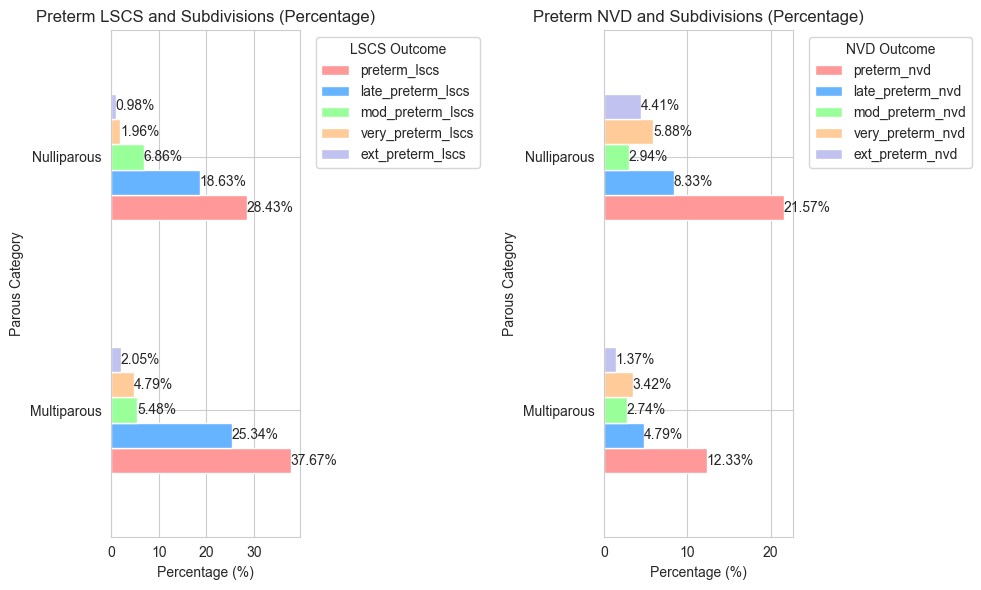

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is the DataFrame with data loaded
# List of columns for total preterm and their subdivisions
total_preterm_columns = ['preterm_lscs', 'preterm_nvd']
preterm_lscs_subdivisions = ['late_preterm_lscs', 'mod_preterm_lscs', 'very_preterm_lscs', 'ext_preterm_lscs']
preterm_nvd_subdivisions = ['late_preterm_nvd', 'mod_preterm_nvd', 'very_preterm_nvd', 'ext_preterm_nvd']

# Grouping and calculating the sum for each category
preterm_lscs_nvd_distribution = df.groupby('PAROUS_ENCODED')[total_preterm_columns + preterm_lscs_subdivisions + preterm_nvd_subdivisions].sum()

# Calculating the percentage distribution for each category
preterm_lscs_nvd_percentage = preterm_lscs_nvd_distribution.div(preterm_lscs_nvd_distribution.sum(axis=1), axis=0) * 100

# Function to add percentage labels to each bar in the plot
def add_percentage_labels(ax):
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', label_type='edge')

# Creating side-by-side horizontal bar charts for LSCS and NVD with percentage labels
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot for LSCS percentage distribution without NVD outcomes
lscs_plot = preterm_lscs_nvd_percentage[total_preterm_columns[:1] + preterm_lscs_subdivisions].plot(
    kind='barh', stacked=False, ax=axes[0], color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
)
axes[0].set_title("Preterm LSCS and Subdivisions (Percentage)")
axes[0].set_xlabel("Percentage (%)")
axes[0].set_ylabel("Parous Category")
axes[0].legend(title='LSCS Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels to LSCS plot
add_percentage_labels(axes[0])

# Plot for NVD percentage distribution without LSCS outcomes
nvd_plot = preterm_lscs_nvd_percentage[total_preterm_columns[1:2] + preterm_nvd_subdivisions].plot(
    kind='barh', stacked=False, ax=axes[1], color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
)
axes[1].set_title("Preterm NVD and Subdivisions (Percentage)")
axes[1].set_xlabel("Percentage (%)")
axes[1].set_ylabel("Parous Category")
axes[1].legend(title='NVD Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels to NVD plot
add_percentage_labels(axes[1])

plt.tight_layout()
plt.show()


In [62]:
label_mapping = {
    'preterm_nvd': 'PTB (NVD)',
    'late_preterm_nvd': 'Late PTB (NVD)',
    'mod_preterm_nvd': 'Moderate PTB (NVD)',
    'very_preterm_nvd': 'Very PTB (NVD)',
    'ext_preterm_nvd': 'Extreme PTB (NVD)',
    'preterm_lscs': 'PTB (LSCS)',
    'late_preterm_lscs': 'Late PTB (LSCS)',
    'mod_preterm_lscs': 'Moderate PTB (LSCS)',
    'very_preterm_lscs': 'Very PTB (LSCS)',
    'ext_preterm_lscs': 'Extreme PTB (LSCS)'
}

In [77]:
df = df.rename(columns=label_mapping)


In [78]:
df

,SL.NO,MT_WEIGHT (KG),MT_AGE (YEARS),MT_HEIGHT (CM),PAROUS,PRVS_LSCS,HYPOTHYROIDISM,IVF/IUI,PPROM,OLIOGOHYDRAMNIOS,...,ext_preterm,Late PTB (LSCS),Moderate PTB (LSCS),Very PTB (LSCS),Extreme PTB (LSCS),Late PTB (NVD),Moderate PTB (NVD),Very PTB (NVD),Extreme PTB (NVD),METHOD-VD/CS
0,1.0,65,34,152,2,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,LSCS
1,2.0,65,28,152,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,LSCS
2,4.0,67,29,152,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,LSCS
3,5.0,68,28,153,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,LSCS
4,6.0,60,26,150,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,NVD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,768.0,64,31,151,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,NVD
729,769.0,59,23,150,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NVD
730,770.0,62,32,152,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,LSCS
731,771.0,69,30,156,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,LSCS


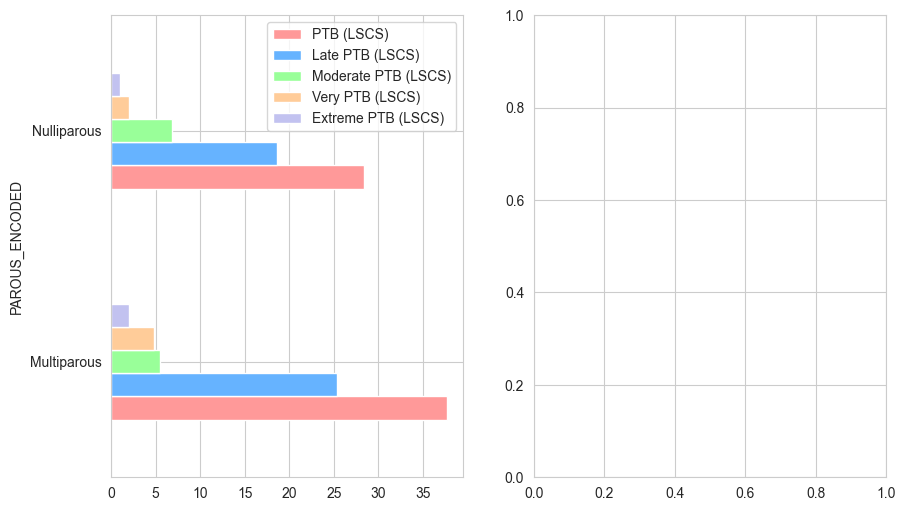

In [79]:
preterm_lscs_subdivisions = ['Late PTB (LSCS)','Moderate PTB (LSCS)','Very PTB (LSCS)','Extreme PTB (LSCS)']
preterm_nvd_subdivisions = ['Late PTB (NVD)','Moderate PTB (NVD)','Very PTB (NVD)','Extreme PTB (NVD)']
total_preterm_columns = ['PTB (LSCS)','PTB (NVD)']

preterm_lscs_nvd_distribution = df.groupby('PAROUS_ENCODED')[total_preterm_columns + preterm_lscs_subdivisions + preterm_nvd_subdivisions].sum()
preterm_lscs_nvd_percentage = preterm_lscs_nvd_distribution.div(preterm_lscs_nvd_distribution.sum(axis=1), axis=0) * 100
preterm_lscs_nvd_percentage_renamed = preterm_lscs_nvd_percentage.rename(columns=label_mapping)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))


# Plot for LSCS percentage distribution without NVD outcomes
lscs_plot = preterm_lscs_nvd_percentage_renamed[total_preterm_columns[:1] + preterm_lscs_subdivisions].plot(
    kind='barh', stacked=False, ax=axes[0], color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
)

In [94]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table2x2

# Assuming your data is in a pandas DataFrame called 'df'
# PAROUS_ENCODED: Column indicating parous/nulliparous status
# target_columns: List of target columns for which we want to calculate odds ratios

# Create a function to compute odds ratio and 95% CI
def compute_odds_ratio_ci(df, target_column):
    # Create contingency table for PAROUS_ENCODED vs target_column
    contingency_table = pd.crosstab(df['PAROUS_ENCODED'], df[target_column])
    
    # Ensure it's a 2x2 table for odds ratio calculation
    if contingency_table.shape == (2, 2):
        table = Table2x2(contingency_table.values)  # 2x2 table
        odds_ratio = table.oddsratio
        ci_low, ci_high = table.oddsratio_confint()  # 95% CI
        return odds_ratio, ci_low, ci_high
    else:
        return np.nan, np.nan, np.nan

# Loop over target columns and compute odds ratios and 95% CIs
target_columns = ['TERM', 'preterm_lscs', 'preterm_nvd', 'late_preterm', 'mod_preterm', 
                  'very_preterm', 'ext_preterm', 'late_preterm_lscs', 'mod_preterm_lscs', 
                  'very_preterm_lscs', 'ext_preterm_lscs', 'late_preterm_nvd', 'mod_preterm_nvd', 
                  'very_preterm_nvd', 'ext_preterm_nvd']

odds_ratios = []

for col in target_columns:
    odds_ratio, ci_low, ci_high = compute_odds_ratio_ci(df, col)
    odds_ratios.append({'Target Column': col, 'Odds Ratio': odds_ratio, 
                        '95% CI Lower': ci_low, '95% CI Upper': ci_high})

# Convert to a DataFrame for easy viewing
odds_ratios_df = pd.DataFrame(odds_ratios)
odds_ratios_df
# Display the odds ratio and confidence interval table

,Target Column,Odds Ratio,95% CI Lower,95% CI Upper
0,TERM,0.798997,0.565045,1.129814
1,preterm_lscs,0.584097,0.390031,0.874722
2,preterm_nvd,1.527038,0.863570,2.700237
3,late_preterm,0.721393,0.470168,1.106855
4,mod_preterm,1.006865,0.484343,2.093097
5,very_preterm,0.798186,0.371849,1.713334
6,ext_preterm,1.336771,0.459511,3.888826
7,late_preterm_lscs,0.585822,0.362589,0.946491
8,mod_preterm_lscs,1.058691,0.438336,2.557005
9,very_preterm_lscs,0.339325,0.098421,1.169884


In [99]:
contingency_table = pd.crosstab(df['PAROUS_ENCODED'], df['TERM'])
contingency_table

table = Table2x2(contingency_table.values)  # 2x2 table
odds_ratio = table.oddsratio
ci_low, ci_high = table.oddsratio_confint()
p_value = table.oddsratio_pvalue()
p_value,odds_ratio, ci_low,ci_high,contingency_table

(0.20427012745449313,
 0.7989967200463052,
 0.5650450660417234,
 1.129813880363329,
 TERM              0    1
 PAROUS_ENCODED          
 Multiparous     203   73
 Nulliparous     355  102)

In [116]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.contingency_tables import Table2x2

# Function to run chi-square test, fisher's exact test, and calculate odds ratios
def run_tests(df, target_column):
    # Create the contingency table
    contingency_table = pd.crosstab(df['PAROUS_ENCODED_BINARY'], df[target_column])
    
    # Initialize results
    chi2_p_value = None
    fisher_p_value = None
    odds_ratio = None
    ci_low = None
    ci_high = None
    
    # If the expected frequencies are all greater than 5, run the Chi-Square test
    if (contingency_table.values >= 5).all():
        _, chi2_p_value, _, _ = chi2_contingency(contingency_table)
    else:
        # Otherwise, run Fisher's Exact Test
        fisher_p_value = fisher_exact(contingency_table)[1]
    
    # Calculate the odds ratio and confidence interval using Table2x2
    if contingency_table.shape == (2, 2):
        table = Table2x2(contingency_table.values)
        odds_ratio = table.oddsratio
        ci_low, ci_high = table.oddsratio_confint()
        ct_p_value = table.oddsratio_pvalue()

    return chi2_p_value, ct_p_value, odds_ratio, ci_low, ci_high

# Run tests for each target column and store results
results = []
target_columns = ['TERM', 'preterm_lscs', 'preterm_nvd', 'late_preterm', 'mod_preterm', 
                  'very_preterm', 'ext_preterm', 'late_preterm_lscs', 'mod_preterm_lscs', 
                  'very_preterm_lscs', 'ext_preterm_lscs', 'late_preterm_nvd', 'mod_preterm_nvd', 
                  'very_preterm_nvd', 'ext_preterm_nvd']

for col in target_columns:
    chi2_p_value, ct_p_value, odds_ratio, ci_low, ci_high = run_tests(df, col)
    results.append({
        'Target Column': col,
        'Chi-Square P-value': chi2_p_value,
        'Odds P-value': ct_p_value,
        'Odds Ratio': odds_ratio,
        '95% CI Lower': ci_low,
        '95% CI Upper': ci_high
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df


,Target Column,Chi-Square P-value,Odds P-value,Odds Ratio,95% CI Lower,95% CI Upper
0,TERM,0.237470,0.204270,1.251570,0.885102,1.769770
1,preterm_lscs,0.011633,0.009065,1.712046,1.143220,2.563898
2,preterm_nvd,0.184384,0.145501,0.654863,0.370338,1.157983
3,late_preterm,0.165142,0.134873,1.386207,0.903461,2.126899
4,mod_preterm,1.000000,0.985381,0.993182,0.477761,2.064652
5,very_preterm,0.703484,0.563004,1.252841,0.583657,2.689267
6,ext_preterm,0.784344,0.594209,0.748071,0.257147,2.176227
7,late_preterm_lscs,0.037741,0.028915,1.707003,1.056534,2.757941
8,mod_preterm_lscs,1.000000,0.899126,0.944563,0.391083,2.281357
9,very_preterm_lscs,NaN,0.086989,2.947026,0.854785,10.160403


In [115]:
p_values = results_df[['Chi-Square P-value', 'Odds P-value']].min(axis=1).dropna()
bonferroni_corrected = multipletests(p_values, method='bonferroni')[1]
fdr_corrected = multipletests(p_values, method='fdr_bh')[1]
results_df['Bonferroni Corrected P-value'] = pd.Series(bonferroni_corrected, index=p_values.index)
results_df['FDR Corrected P-value'] = pd.Series(fdr_corrected, index=p_values.index)

# Display the results
results_df

,Target Column,Chi-Square P-value,Odds P-value,Odds Ratio,95% CI Lower,95% CI Upper,Bonferroni Corrected P-value,FDR Corrected P-value
0,TERM,0.237470,0.204270,1.251570,0.885102,1.769770,1.000000,0.437722
1,preterm_lscs,0.011633,0.009065,1.712046,1.143220,2.563898,0.135982,0.135982
2,preterm_nvd,0.184384,0.145501,0.654863,0.370338,1.157983,1.000000,0.436502
3,late_preterm,0.165142,0.134873,1.386207,0.903461,2.126899,1.000000,0.436502
4,mod_preterm,1.000000,0.985381,0.993182,0.477761,2.064652,1.000000,0.985381
5,very_preterm,0.703484,0.563004,1.252841,0.583657,2.689267,1.000000,0.742761
6,ext_preterm,0.784344,0.594209,0.748071,0.257147,2.176227,1.000000,0.742761
7,late_preterm_lscs,0.037741,0.028915,1.707003,1.056534,2.757941,0.433731,0.216866
8,mod_preterm_lscs,1.000000,0.899126,0.944563,0.391083,2.281357,1.000000,0.963349
9,very_preterm_lscs,NaN,0.086989,2.947026,0.854785,10.160403,1.000000,0.434947


/var/folders/5h/lcrw0nbj4n1592ysvkv4w74m0000gr/T/ipykernel_19276/2342126281.py:20: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(lscs_columns, lscs_odds_ratios, yerr=lscs_error, fmt='o', capsize=5, capthick=2, elinewidth=2, marker='s', markersize=5)


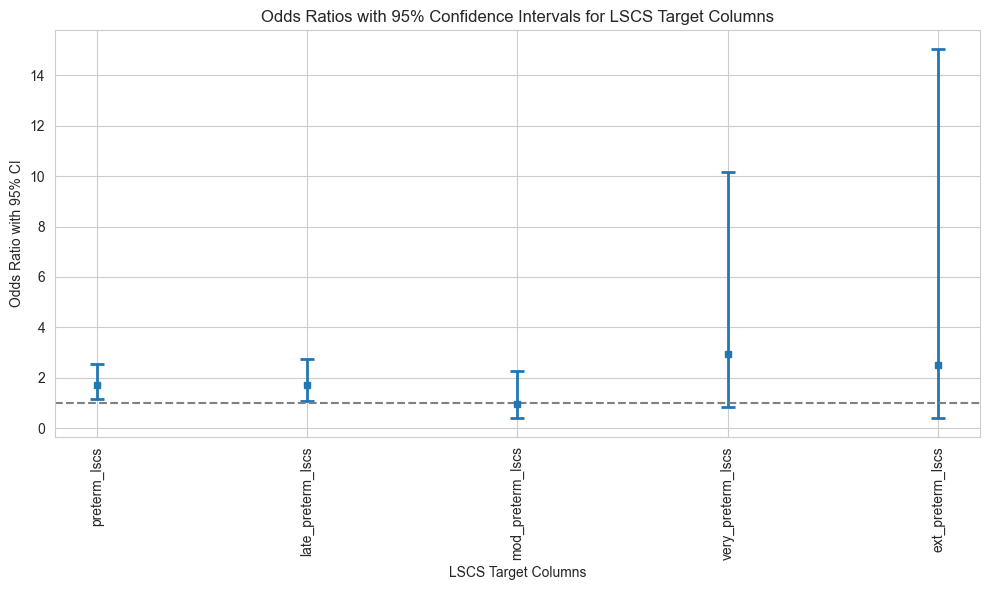

In [113]:
lscs_columns = [col for col in target_columns if 'lscs' in col]
nvd_columns = [col for col in target_columns if 'nvd' in col]

# Extract data for LSCS
lscs_data = results_df[results_df['Target Column'].isin(lscs_columns)]
lscs_odds_ratios = lscs_data['Odds Ratio']
lscs_ci_lower = lscs_data['95% CI Lower']
lscs_ci_upper = lscs_data['95% CI Upper']
lscs_error = [lscs_odds_ratios - lscs_ci_lower, lscs_ci_upper - lscs_odds_ratios]

# Extract data for NVD
nvd_data = results_df[results_df['Target Column'].isin(nvd_columns)]
nvd_odds_ratios = nvd_data['Odds Ratio']
nvd_ci_lower = nvd_data['95% CI Lower']
nvd_ci_upper = nvd_data['95% CI Upper']
nvd_error = [nvd_odds_ratios - nvd_ci_lower, nvd_ci_upper - nvd_odds_ratios]

# Plot for LSCS
plt.figure(figsize=(10, 6))
plt.errorbar(lscs_columns, lscs_odds_ratios, yerr=lscs_error, fmt='o', capsize=5, capthick=2, elinewidth=2, marker='s', markersize=5)
plt.axhline(1, color='gray', linestyle='--')  # Reference line at OR = 1
plt.xticks(rotation=90)
plt.xlabel('LSCS Target Columns')
plt.ylabel('Odds Ratio with 95% CI')
plt.title('Odds Ratios with 95% Confidence Intervals for LSCS Target Columns')
plt.tight_layout()
plt.show()